<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.10.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (colab has CUDA 11.1 + torch 1.9)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.10")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [ ]:
!pip install --upgrade mxnet-cu101 gluoncv

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar  7 23:21:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Some basic setup:

# import some common libraries
import os, json, cv2, random, re, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

from gluoncv.utils import download, viz
import gluoncv as gcv

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the RGB fluorescence images of CTC model sample slides under 20X obj which only have one class: CTCs.
We'll train a CTC detection model from an existing model pre-trained on COCO/Pascal VOC dataset, available in [detectron2's model zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Note that COCO dataset does not have the "CTC" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
from google.colab import files, drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
print(os.listdir('/content/gdrive/My Drive/'))
# files.download("data/training_and_test_accuracies.png")

Mounted at /content/gdrive
['Colab Notebooks', 'Dataset', 'Shared_with_me', 'GitHub_AI4Embryo', 'Shared_files', 'FPM-A experiment', 'Images']


In [ ]:
root_path = '/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CTC_only_by_slide_MATLAB_CTC_BB_anno_clean'

VOC_path = os.path.join(root_path, 'VOC2018')
annot_path = os.path.join(VOC_path, 'Annotations')
split_path = os.path.join(VOC_path, 'ImageSets', 'Main')
image_path = os.path.join(VOC_path, 'JPEGImages')

dataset_text = {}
dataset_text["train"] = os.path.join(split_path, "train.txt")
dataset_text["val"] = os.path.join(split_path, "test.txt")

In [ ]:
npzfile = np.load(os.path.join(VOC_path, 'train_mean_std.npz'))
X_mean = npzfile['X_mean'].tolist()
X_std = npzfile['X_std'].tolist()
print('RGB')
print(X_mean)
print(X_std)

RGB
[8.878484982, 6.782542444, 33.381502166]
[16.88976592054826, 24.339260915030035, 44.59486385379693]


Register my CTC dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_pol_dicts(dataset_txt, dataset_image_path):
  # Generate dataset_dict for train and val
  with open(dataset_txt) as f:
      content = f.readlines()
  content = [x.strip() for x in content] 
  imlist = []
  for img_name in content:
    imlist.append(img_name+'.jpg')

  dataset_dicts = []
  for img_id, v in enumerate(imlist):
      record = {}
      
      filename = os.path.join(dataset_image_path, v)
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = img_id
      record["height"] = height
      record["width"] = width

      anno_name = annot_path+'/'+os.path.splitext(v)[0]+'.xml'
      objs = []
      # read in anno file
      tree = ET.parse(anno_name) 
      root = tree.getroot()
      # update the filename value in xml file according to its new name
      for obj in root.iter('object'):
        xmin = int(obj[4][0].text)
        ymin = int(obj[4][1].text)
        xmax = int(obj[4][2].text)
        ymax = int(obj[4][3].text)
        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("CTC_" + d, lambda d=d: get_pol_dicts(dataset_text[d], image_path))
    MetadataCatalog.get("CTC_" + d).set(thing_classes=["CTC"])

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [ ]:
CTC_train_metadata = MetadataCatalog.get("CTC_train")
train_dataset_dicts = get_pol_dicts(dataset_text["train"], image_path)

OpenCV load -> OpenCV visualize

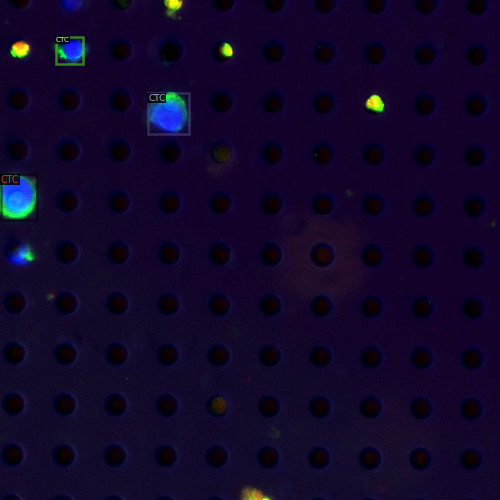

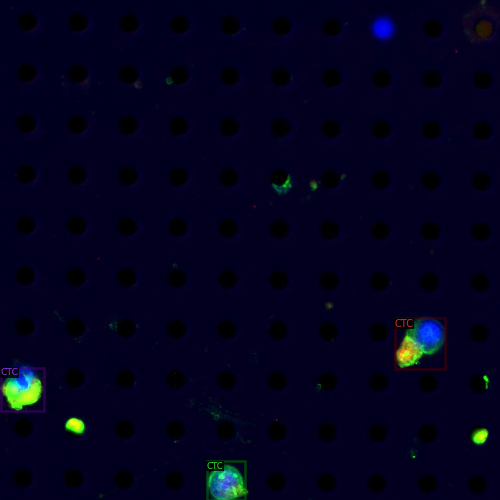

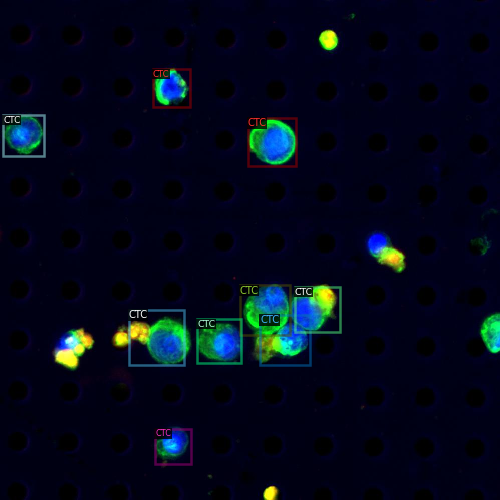

In [ ]:
# OpenCV uses BGR image format. So, when we read an image using cv2.imread() it interprets in BGR format by default.
for d in random.sample(train_dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=CTC_train_metadata, scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

OpenCV load -> plt visualize

In [ ]:
# define a helper to display multiple images in a column in notebook
def show_images(images, titles, cmaps):
  num_images = len(images)
  rows, cols = num_images, 1
  fig, axs = plt.subplots(rows, cols, figsize=(5, 12))
  for i in range(num_images):
      if len(images[i].shape)==2:
        im = axs[i].imshow(images[i], cmap=cmaps[i])
      else:
        im = axs[i].imshow(images[i], cmap=None)
      axs[i].set_title(titles[i])
  plt.tight_layout()
  return fig

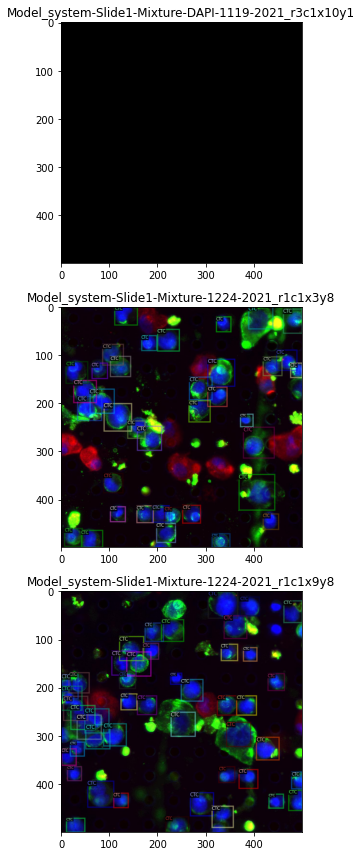

In [ ]:
train_img_samples = []
titles = []

rs = 69
random.seed(rs)
for d in random.sample(train_dataset_dicts, 3):
  image_bgr = cv2.imread(d["file_name"])
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  visualizer = Visualizer(image_rgb[:, :, ::-1], metadata=CTC_train_metadata, scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  train_img_samples.append(out.get_image()[:, :, ::-1])
  titles.append(os.path.splitext(os.path.basename(d["file_name"]))[0])

cmaps = [None,None,None]
fig2 = show_images(np.array(train_img_samples), titles, cmaps)

## Train!

Now, let's fine-tune a COCO-pretrained model on the CTC dataset.

https://detectron2.readthedocs.io/en/latest/modules/config.html

In [ ]:
# COCO-Detection/retinanet_R_50_FPN_3x.yaml
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
# Values to be used for image normalization (BGR order, since INPUT.FORMAT defaults to BGR).
# To train on images of different number of channels, just set different mean & std.
# Default values are the mean pixel value from ImageNet: [103.53, 116.28, 123.675]
cfg.MODEL.PIXEL_MEAN = [X_mean[2], X_mean[1], X_mean[0]]
# When using pre-trained models in Detectron1 or any MSRA models,
# std has been absorbed into its conv1 weights, so the std needs to be set 1.
# Otherwise, you can use [57.375, 57.120, 58.395] (ImageNet std)
cfg.MODEL.PIXEL_STD = [1.0, 1.0, 1.0]

cfg.DATASETS.TRAIN = ("CTC_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 # 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only has one class (CTC)
cfg.MODEL.RETINANET.NUM_CLASSES = 1 # only has one class (CTC)
# (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 1000 # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

saving_path = "/content/gdrive/My Drive/Colab Notebooks/Research_project_CTC_detection/Detectron2_CTC_only_split_by_slide_MATLAB_CTC_BB/retinanet_R101_FPN_0.00025_trial5"
cfg.OUTPUT_DIR = saving_path

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/05 05:21:44 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:12, 17.8MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[03/05 05:33:18 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/05 05:33:29 d2.utils.events]:  eta: 0:09:08  iter: 19  total_loss: 1.33  loss_cls: 1.011  loss_box_reg: 0.325  time: 0.5505  data_time: 0.0217  lr: 4.9953e-06  max_mem: 2079M
[03/05 05:33:35 d2.utils.events]:  eta: 0:08:37  iter: 39  total_loss: 1.067  loss_cls: 0.8718  loss_box_reg: 0.1949  time: 0.3957  data_time: 0.0084  lr: 9.9902e-06  max_mem: 2101M
[03/05 05:33:38 d2.utils.events]:  eta: 0:03:14  iter: 59  total_loss: 0.8889  loss_cls: 0.7023  loss_box_reg: 0.1722  time: 0.3225  data_time: 0.0074  lr: 1.4985e-05  max_mem: 2101M
[03/05 05:33:42 d2.utils.events]:  eta: 0:03:08  iter: 79  total_loss: 0.4399  loss_cls: 0.357  loss_box_reg: 0.08066  time: 0.2906  data_time: 0.0068  lr: 1.998e-05  max_mem: 2101M
[03/05 05:33:46 d2.utils.events]:  eta: 0:03:01  iter: 99  total_loss: 0.6298  loss_cls: 0.5384  loss_box_reg: 0.1144  time: 0.2701  data_time: 0.0064  lr: 2.4975e-05  max_mem: 2118M
[03/05 05:33:50 d2.utils.events]:  eta: 0:02:52  iter: 119  total_loss: 0.5449  loss_cls: 0

## Generate prediction for testing dataset
Now, let's run inference with the trained model on the testing dataset. First, let's create a predictor using the model we just trained:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.05 # set a custom testing threshold for this model, default = 0.05
cfg.DATASETS.TEST = ("CTC_val",)

predictor = DefaultPredictor(cfg)

val_dataset_dicts = get_pol_dicts(dataset_text["val"], image_path)
CTC_val_metadata = MetadataCatalog.get("CTC_val")

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
evaluator = COCOEvaluator("CTC_val", cfg, False, output_dir=saving_path)
val_loader = build_detection_test_loader(cfg, "CTC_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

WARNING [03/05 06:14:15 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/05 06:14:15 d2.evaluation.coco_evaluation]: Trying to convert 'CTC_val' to COCO format ...
[03/05 06:14:15 d2.data.datasets.coco]: Converting annotations of dataset 'CTC_val' to COCO format ...)
[03/05 06:14:17 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/05 06:14:17 d2.data.datasets.coco]: Conversion finished, #images: 100, #annotations: 1933
[03/05 06:14:17 d2.data.datasets.coco]: Caching COCO format annotations at '/content/gdrive/My Drive/Colab Notebooks/Research_project_CTC_detection/Detectron2_CTC_only_split_by_slide_MATLAB_CTC_BB/retinanet_R101_FPN_0.00025_trial6/CTC_val_coco_format.json' ...
[03/05 06:14:19 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    CTC     | 1933         |
|            |        

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[03/05 06:14:20 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0032 s/iter. Inference: 0.0624 s/iter. Eval: 0.0006 s/iter. Total: 0.0662 s/iter. ETA=0:00:05
[03/05 06:14:25 d2.evaluation.evaluator]: Inference done 88/100. Dataloading: 0.0036 s/iter. Inference: 0.0615 s/iter. Eval: 0.0004 s/iter. Total: 0.0656 s/iter. ETA=0:00:00
[03/05 06:14:26 d2.evaluation.evaluator]: Total inference time: 0:00:06.222049 (0.065495 s / iter per device, on 1 devices)
[03/05 06:14:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.060793 s / iter per device, on 1 devices)
[03/05 06:14:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/05 06:14:26 d2.evaluation.coco_evaluation]: Saving results to /content/gdrive/My Drive/Colab Notebooks/Research_project_CTC_detection/Detectron2_CTC_only_split_by_slide_MATLAB_CTC_BB/retinanet_R101_FPN_0.00025_trial6/coco_instances_results.json
[03/05 06:14:26 d2.evaluation.coco_evaluation]: Evaluating pred

##### My evaluation

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner
    bb2 : list
        arrangement: [xmin, ymin, xmax, ymax]
        The (xmin, ymin) position is at the top left corner,
        the (xmax, ymax) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def remove_overlap(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  for ele in sorted(remove_idx, reverse = True):
    del final_pred_bboxes[ele]
  return final_pred_bboxes
  
def remove_overlap_idx(final_pred_bboxes, iou_thre):
  # Remove the overlapping predicted boxes coming later (with lower score) 
  # Input:
  #    final_pred_bboxes: list, predicted bounding boxes, with the format of [xmin, ymin, xmax, ymax]
  #    iou_thre: double, threshold to judge if overlapping
  # Output:
  #    final_pred_bboxes without overlapping boxes: list
  num_pred_bboxes = len(final_pred_bboxes)
  to_remove = []
  for k in range(num_pred_bboxes):
    base_bbox = final_pred_bboxes[k]
    for t in range(k+1,num_pred_bboxes):
      iou_test = get_iou(final_pred_bboxes[t], base_bbox)
      if iou_test>iou_thre:
        to_remove.append(t)
  remove_idx = np.unique(np.array(to_remove))
  return remove_idx

def coco_instances_bbox_convert(coco_bbox):
  # coco_instances_results.json -> df_pred -> bbox: [xmin, ymin, x_size, y_size]
  # What to do: [xmin, ymin, x_size, y_size] -> [xmin, ymin, xmax, ymax]
  new_bbox = []
  new_bbox.append(coco_bbox[0])
  new_bbox.append(coco_bbox[1])
  new_bbox.append(coco_bbox[0]+coco_bbox[2])
  new_bbox.append(coco_bbox[1]+coco_bbox[3])
  return new_bbox

In [ ]:
# Annotation excel
df_anno1 = pd.DataFrame.from_dict(val_dataset_dicts).explode('annotations').reset_index()
df_anno2 = pd.json_normalize(df_anno1['annotations'])
df_anno = pd.concat([df_anno1, df_anno2], axis=1).drop(columns=['index', 'height', 'width', 'annotations', 'bbox_mode'])

print(df_anno)
df_anno.head()

                                              file_name  image_id  \
0     /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
1     /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
2     /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
3     /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
4     /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...         0   
...                                                 ...       ...   
1924  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
1925  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
1926  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
1927  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   
1928  /content/gdrive/My Drive/Dataset/VOC_ModelSmp_...        99   

                       bbox  category_id  
0      [111, 468, 211, 558]          0.0  
1      [221, 700, 304, 786]          0.0  
2      [280, 742, 360, 811]          0.0  

,file_name,image_id,bbox,category_id
0,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,"[111, 468, 211, 558]",0.0
1,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,"[221, 700, 304, 786]",0.0
2,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,"[280, 742, 360, 811]",0.0
3,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,"[319, 677, 404, 756]",0.0
4,/content/gdrive/My Drive/Dataset/VOC_ModelSmp_...,0,"[426, 606, 509, 690]",0.0


In [ ]:
# Prediction excel
json_file = os.path.join(saving_path, 'coco_instances_results.json')
df_pred = pd.read_json(json_file) # df_pred is already sorted by 'image_id' and then 'score'
# df_pred.sort_values(['image_id', 'score'], ascending=[False, False], inplace = False)
df_pred['bbox'] = df_pred['bbox'].apply(coco_instances_bbox_convert)

print(df_pred)
df_pred.head()

      image_id  category_id  \
0            0            0   
1            0            0   
2            0            0   
3            0            0   
4            0            0   
...        ...          ...   
6340        99            0   
6341        99            0   
6342        99            0   
6343        99            0   
6344        99            0   

                                                   bbox     score  
0     [711.278564453125, 815.509765625, 798.12939453...  0.856066  
1     [547.2265014648438, 492.96337890625, 621.40069...  0.840902  
2     [694.4364013671875, 728.767578125, 791.8880615...  0.840034  
3     [629.047607421875, 311.76153564453125, 719.933...  0.816156  
4     [426.60565185546875, 879.9390258789062, 510.73...  0.805936  
...                                                 ...       ...  
6340  [95.05619812011719, 262.05157470703125, 296.60...  0.052809  
6341  [24.53033447265625, 307.8585510253906, 250.664...  0.051478  
6342  [111.9612

,image_id,category_id,bbox,score
0,0,0,"[711.278564453125, 815.509765625, 798.12939453...",0.856066
1,0,0,"[547.2265014648438, 492.96337890625, 621.40069...",0.840902
2,0,0,"[694.4364013671875, 728.767578125, 791.8880615...",0.840034
3,0,0,"[629.047607421875, 311.76153564453125, 719.933...",0.816156
4,0,0,"[426.60565185546875, 879.9390258789062, 510.73...",0.805936


/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CTC_only_by_slide_MATLAB_CTC_BB_anno_clean/VOC2018/JPEGImages/Model_system-Slide2-Mixture-1225-2021_r1c1x4y5.jpg


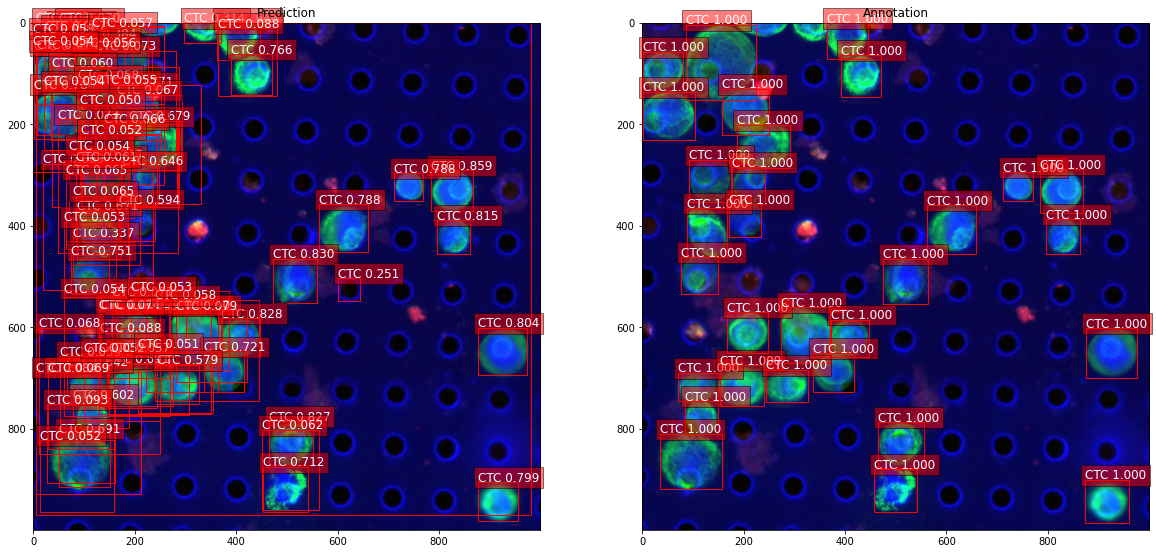

In [ ]:
# visualize the prediction and annotation side by side -> thresh = 0.05
image_id = 45
file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
print(file_name)
x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

pred_bboxes = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['bbox']))
pred_scores = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['score']))
pred_cids = np.asarray(list(df_pred.loc[df_pred.image_id==image_id]['category_id']))

anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
anno_scores = np.ones(anno_cids.shape)

# thresh (float, optional, default 0.5) – Display threshold if scores is provided.
# Scores with less than thresh will be ignored in display, this is visually more elegant
# if you have a large number of bounding boxes with very small scores.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=0.05, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=12)
ax1.set_title('Prediction')

ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=0.05, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=12)
ax2.set_title('Annotation')
plt.show()

In [ ]:
# select detections with score higher than threshold
score_thre = 0.5 # RetinaNet
df_pred_slt = df_pred[df_pred['score']>score_thre].reset_index(drop=True)

print(df_pred_slt)
df_pred_slt.head()

      image_id  category_id  \
0            0            0   
1            0            0   
2            0            0   
3            0            0   
4            0            0   
...        ...          ...   
2199        99            0   
2200        99            0   
2201        99            0   
2202        99            0   
2203        99            0   

                                                   bbox     score  
0     [111.49980163574219, 465.4379577636719, 206.61...  0.932963  
1     [693.7686157226562, 727.2378540039062, 792.064...  0.920333  
2     [627.6900634765625, 311.16778564453125, 720.40...  0.919665  
3     [547.0630493164062, 492.1405334472656, 621.582...  0.916950  
4     [889.5712890625, 0.0, 977.3192749023438, 76.31...  0.907073  
...                                                 ...       ...  
2199  [242.56759643554688, 20.68413734436035, 352.98...  0.559645  
2200  [124.75706481933594, 262.7820129394531, 200.80...  0.557129  
2201  [68.37783

,image_id,category_id,bbox,score
0,0,0,"[111.49980163574219, 465.4379577636719, 206.61...",0.932963
1,0,0,"[693.7686157226562, 727.2378540039062, 792.064...",0.920333
2,0,0,"[627.6900634765625, 311.16778564453125, 720.40...",0.919665
3,0,0,"[547.0630493164062, 492.1405334472656, 621.582...",0.916950
4,0,0,"[889.5712890625, 0.0, 977.3192749023438, 76.31...",0.907073


In [ ]:
# clean detections by removing overlapping bounding boxes
clean_iou_thre = 0.2
pred_image_ids = np.unique(df_pred_slt['image_id'].to_numpy())
df_pred_slt_clean = []
count = 0
for image_id in pred_image_ids:
  df_pred_image_id = df_pred_slt.loc[df_pred_slt.image_id==image_id].reset_index(drop=True)
  pred_bboxes = list(df_pred_image_id['bbox'])
  remove_idx = remove_overlap_idx(pred_bboxes, clean_iou_thre)
  df_pred_image_id_clean = df_pred_image_id.drop(remove_idx)
  if count == 0:
    df_pred_slt_clean = df_pred_image_id_clean
  else:
    df_pred_slt_clean = pd.concat([df_pred_slt_clean, df_pred_image_id_clean], axis=0)
  count = count+1

print(df_pred_slt_clean)
df_pred_slt_clean.head()

    image_id  category_id                                               bbox  \
0          0            0  [111.49980163574219, 465.4379577636719, 206.61...   
1          0            0  [693.7686157226562, 727.2378540039062, 792.064...   
2          0            0  [627.6900634765625, 311.16778564453125, 720.40...   
3          0            0  [547.0630493164062, 492.1405334472656, 621.582...   
4          0            0  [889.5712890625, 0.0, 977.3192749023438, 76.31...   
..       ...          ...                                                ...   
25        99            0  [70.86322021484375, 660.39013671875, 163.07223...   
27        99            0  [855.799560546875, 283.46038818359375, 902.925...   
28        99            0  [119.50044250488281, 709.024169921875, 194.753...   
29        99            0  [181.85577392578125, 47.34988784790039, 274.73...   
33        99            0  [290.2691955566406, 199.3025360107422, 351.938...   

       score  
0   0.932963  
1   0.920

,image_id,category_id,bbox,score
0,0,0,"[111.49980163574219, 465.4379577636719, 206.61...",0.932963
1,0,0,"[693.7686157226562, 727.2378540039062, 792.064...",0.920333
2,0,0,"[627.6900634765625, 311.16778564453125, 720.40...",0.919665
3,0,0,"[547.0630493164062, 492.1405334472656, 621.582...",0.916950
4,0,0,"[889.5712890625, 0.0, 977.3192749023438, 76.31...",0.907073


/content/gdrive/My Drive/Dataset/VOC_ModelSmp_CTC_only_by_slide_MATLAB_CTC_BB_anno_clean/VOC2018/JPEGImages/Model_system-Slide2-Mixture-1225-2021_r1c1x4y5.jpg


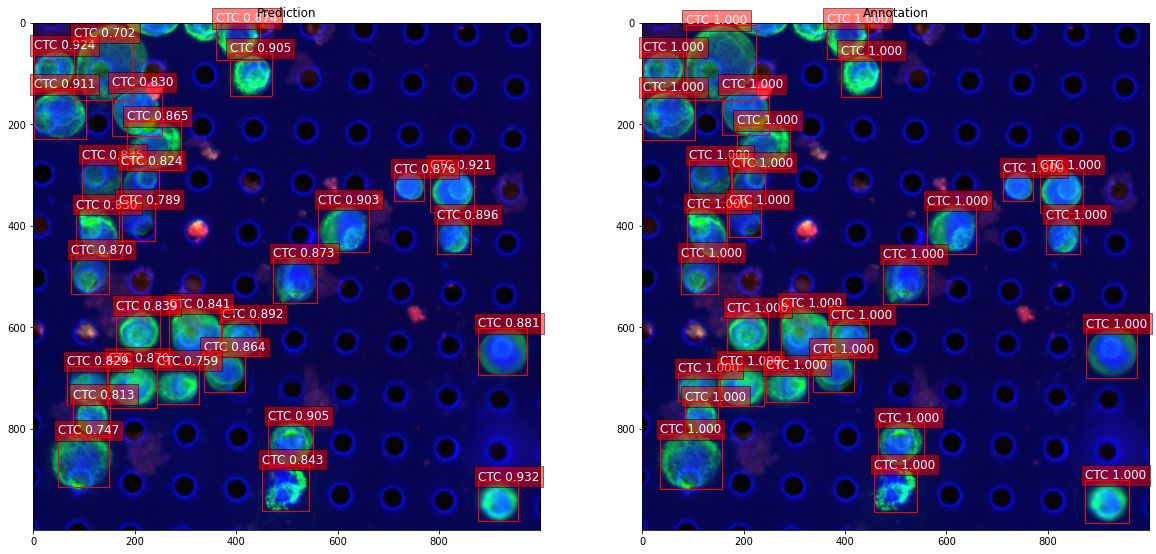

In [ ]:
# visualize the prediction and annotation side by side -> thresh = 0.4
image_id = 45
file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
print(file_name)
x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

pred_bboxes = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox']))
pred_scores = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score']))
pred_cids = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['category_id']))

anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
anno_scores = np.ones(anno_cids.shape)

# thresh (float, optional, default 0.5) – Display threshold if scores is provided.
# Scores with less than thresh will be ignored in display, this is visually more elegant
# if you have a large number of bounding boxes with very small scores.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=score_thre, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=12)
ax1.set_title('Prediction')

ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=score_thre, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=12)
ax2.set_title('Annotation')
plt.show()

In [ ]:
# save the displayed testing image example
from scipy.io import savemat

mdic = {"image": image, "pred_bboxes": pred_bboxes, "anno_bboxes": anno_bboxes}
savemat("detection1.mat", mdic)

In [ ]:
# output all the testing images with both annotated and predicted bounding boxes
test_saving_path = os.path.join(saving_path,'test_prediciton_scoreTH'+str(score_thre)+'cleanIoUTH'+str(clean_iou_thre))
os.makedirs(test_saving_path, exist_ok=True)

image_ids = np.unique(df_anno['image_id'].to_numpy())
for image_id in image_ids:
  file_name = df_anno[df_anno['image_id']==image_id]['file_name'].tolist()[0]
  x, image = gcv.data.transforms.presets.ssd.load_test(file_name, 1000)

  pred_bboxes = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox']))
  pred_scores = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score']))
  pred_cids = np.asarray(list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['category_id']))

  anno_bboxes = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['bbox']))
  anno_cids = np.asarray(list(df_anno.loc[df_anno.image_id==image_id]['category_id']))
  anno_scores = np.ones(anno_cids.shape)

  # thresh (float, optional, default 0.5) – Display threshold if scores is provided.
  # Scores with less than thresh will be ignored in display, this is visually more elegant
  # if you have a large number of bounding boxes with very small scores.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  ax1 = viz.plot_bbox(image, pred_bboxes, pred_scores, pred_cids, thresh=score_thre, class_names=['CTC'], ax=ax1, linewidth=1, fontsize=8)
  ax1.set_title('Prediction')

  if np.sum(np.isnan(anno_bboxes)):
    ax2.imshow(image)
    ax2.set_title('Annotation')
  else:
    ax2 = viz.plot_bbox(image, anno_bboxes, anno_scores, anno_cids, thresh=score_thre, class_names=['CTC'], ax=ax2, linewidth=1, fontsize=8)
    ax2.set_title('Annotation')
  fig.savefig(os.path.join(test_saving_path,os.path.splitext(os.path.basename(file_name))[0]+'.png'))

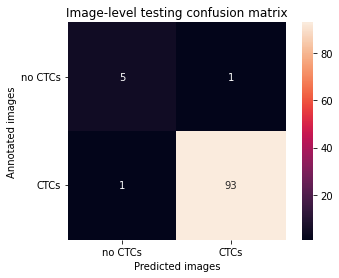

In [ ]:
# find images without annotation or without prediction
import seaborn as sns
def flag_nan(bbox):
    return np.sum(np.isnan(np.array(bbox)))

df_anno_clean = df_anno.loc[df_anno['bbox'].apply(flag_nan) == 0] # 1614-62 = 1552
anno_image_ids = np.unique(df_anno_clean['image_id'].to_numpy())
pred_image_ids = np.unique(df_pred_slt_clean['image_id'].to_numpy())

num_TT = len(np.intersect1d(anno_image_ids,pred_image_ids))
num_TF = len(anno_image_ids)-len(np.intersect1d(anno_image_ids,pred_image_ids))
num_FT = len(pred_image_ids)-len(np.intersect1d(anno_image_ids,pred_image_ids))
num_FF = len(np.unique(df_anno['image_id'].to_numpy()))-len(pred_image_ids)-num_TF

labels = ['no CTCs','CTCs']
cm = [[num_FF,num_FT],[num_TF,num_TT]]
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted images')
ax.set_ylabel('Annotated images')
ax.set_title('Image-level testing confusion matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation='horizontal')
ax.set_aspect('equal', 'box')

In [ ]:
iou_thre = 0.5 # threshold for evaluation IoU

# precision
numerator1 = 0
denominator1 = 0
# recall
numerator2 = 0
denominator2 = 0

test_image_ids = np.unique(df_anno['image_id'].to_numpy())
test_matrix_list = []
for image_id in test_image_ids:
  if image_id in np.unique(df_pred_slt_clean['image_id'].to_numpy()): # at least one predicted box for this test image
    pred_bboxes = list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['bbox'])
    pred_scores = list(df_pred_slt_clean.loc[df_pred_slt_clean.image_id==image_id]['score'])
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if np.sum(np.isnan(np.array(anno_bboxes))): # no annotated box for this test image
      denominator1 = denominator1+len(pred_scores)
    else: # at least one annotated box for this test image
      iou_matrix = np.zeros([len(pred_bboxes),len(anno_bboxes)])
      for pred_idx, pred_bbox in enumerate(pred_bboxes):
        for anno_idx, anno_bbox in enumerate(anno_bboxes):
          iou_matrix[pred_idx, anno_idx] = get_iou(pred_bbox, anno_bbox)
      # # only keep the first successful prediction for each column of annotated object
      # # WRONG! -> cannot rule out the possibility that a prediction box successfully predicts two annotation boxes
      # success_matrix = iou_matrix > iou_thre
      # success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      success_matrix = []
      for k in range(iou_matrix.shape[0]): # scan through prediction boxes by row
        pred_row = iou_matrix[k,:] > iou_thre
        if np.sum(pred_row)>1: # make sure a prediction box will not be used twice
          pred_row = iou_matrix[k,:] == np.max(iou_matrix[k,:])
        if k==0:
          success_matrix = pred_row
        else:
          success_matrix = np.vstack((success_matrix,pred_row))
      success_matrix_clean = success_matrix.cumsum(axis=0).cumsum(axis=0) == 1
      test_matrix_list.append(success_matrix_clean)
  else: # no predicted box for this test image
    anno_bboxes = list(df_anno.loc[df_anno.image_id==image_id]['bbox'])
    if not np.sum(np.isnan(np.array(anno_bboxes))): # at least one annotated box for this test image
      denominator2 = denominator2+len(anno_bboxes)

for success_matrix_clean in test_matrix_list:
  numerator1 = numerator1+np.sum(success_matrix_clean)
  numerator2 = numerator2+np.sum(success_matrix_clean)
  if len(success_matrix_clean.shape)==1:
    denominator1 = denominator1+1
    denominator2 = denominator2+1
  else:
    denominator1 = denominator1+success_matrix_clean.shape[0]
    denominator2 = denominator2+success_matrix_clean.shape[1]

precision = numerator1/denominator1
recall = numerator2/denominator2

print('%d out of %d predicted CTCs are true CTCs.' % (numerator1, denominator1))
print('%d out of %d annotated CTCs are detected.' % (numerator2, denominator2))
print('Correct detection: %d; Missed detection: %d; Wrong detection: %d.' % (numerator1, denominator2-numerator2, denominator1-numerator1))
print('Precision = %.1f%%, Recall = %.1f%%' % (precision*100, recall*100))

1854 out of 1928 predicted CTCs are true CTCs.
1854 out of 1924 annotated CTCs are detected.
Correct detection: 1854; Missed detection: 70; Wrong detection: 74.
Precision = 96.2%, Recall = 96.4%
